In [1]:
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
import optuna
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import scale_data, inverse_transform, scatterplot, lineplot
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('Data/all_data.xlsx')
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [3]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [4]:
X = df.drop(columns=["Date", "Adj_Close", "Close"])  
y = df["Close"] 

In [5]:
# Membuat skenario dan scaling
scenarios = {
    "scen1": ["Open", "High", "Low"],  # Harga saja
    "scen2": ["Open", "High", "Low", "Sentimen"],  # Harga + Sentimen
    "scen3": ["Open", "High", "Low", "Index"],  # Harga + Index
    "scen4": ["Open", "High", "Low", "Volume"],  # Harga + Volume
    "scen5": ["Open", "High", "Low", "Sentimen", "Index"],  # Harga + Sentimen + Index
    "scen6": ["Open", "High", "Low", "Sentimen", "Volume"],  # Harga + Sentimen + Volume
    "scen7": ["Open", "High", "Low", "Volume", "Index"],  # Harga + Volume + Index
    "scen8": ["Open", "High", "Low", "Sentimen", "Index", "Volume"]  # Harga + Sentimen + Index + Volume
}

scaled_scenarios = {}

for scen_name, columns in scenarios.items():
    X, y, scaler = scale_data(df, subset_columns=columns, target_column="Close")
    scaled_scenarios[scen_name] = (X, y)

In [6]:
# Mendefinisikan X dan y untuk setiap skenario
for i, scen in enumerate(scenarios, start=1):
    X_name = f"X_scen{i}"
    y_name = f"y_scen{i}"
    
    globals()[X_name], globals()[y_name] = scaled_scenarios[scen]
    
    print(f"{X_name}: {globals()[X_name].shape}")
    print(f"{y_name}: {globals()[y_name].shape}")


X_scen1: (365, 1, 3)
y_scen1: (365,)
X_scen2: (365, 1, 4)
y_scen2: (365,)
X_scen3: (365, 1, 4)
y_scen3: (365,)
X_scen4: (365, 1, 4)
y_scen4: (365,)
X_scen5: (365, 1, 5)
y_scen5: (365,)
X_scen6: (365, 1, 5)
y_scen6: (365,)
X_scen7: (365, 1, 5)
y_scen7: (365,)
X_scen8: (365, 1, 6)
y_scen8: (365,)


In [7]:
for i, scen in enumerate(scenarios, start=1):
    X_data, y_data = scaled_scenarios[scen]
    
    # Membagi data menjadi train dan test set
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    
    globals()[f"X_train_scen{i}"] = X_train
    globals()[f"X_test_scen{i}"] = X_test
    globals()[f"y_train_scen{i}"] = y_train
    globals()[f"y_test_scen{i}"] = y_test
    
    print(f"Train/Test Split for scen{i}:")
    print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

    print("="*50)

Train/Test Split for scen1:
X_train: (292, 1, 3), X_test: (73, 1, 3)
y_train: (292,), y_test: (73,)
Train/Test Split for scen2:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen3:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen4:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen5:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen6:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen7:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen8:
X_train: (292, 1, 6), X_test: (73, 1, 6)
y_train: (292,), y_test: (73,)


In [8]:
for i in range(1, 9): 
    X_train_data = globals()[f"X_train_scen{i}"]
    X_test_data = globals()[f"X_test_scen{i}"]

    # reshaping
    X_train_data = X_train_data.reshape(X_train_data.shape[0] * X_train_data.shape[1], X_train_data.shape[2])
    X_test_data = X_test_data.reshape(X_test_data.shape[0] * X_test_data.shape[1], X_test_data.shape[2])

    globals()[f"X_train_scen{i}"] = X_train_data
    globals()[f"X_test_scen{i}"] = X_test_data

    print(f"Reshaped X_train_scen{i}: {X_train_data.shape}")
    print(f"Reshaped X_test_scen{i}: {X_test_data.shape}")
    print("="*50)

Reshaped X_train_scen1: (292, 3)
Reshaped X_test_scen1: (73, 3)
Reshaped X_train_scen2: (292, 4)
Reshaped X_test_scen2: (73, 4)
Reshaped X_train_scen3: (292, 4)
Reshaped X_test_scen3: (73, 4)
Reshaped X_train_scen4: (292, 4)
Reshaped X_test_scen4: (73, 4)
Reshaped X_train_scen5: (292, 5)
Reshaped X_test_scen5: (73, 5)
Reshaped X_train_scen6: (292, 5)
Reshaped X_test_scen6: (73, 5)
Reshaped X_train_scen7: (292, 5)
Reshaped X_test_scen7: (73, 5)
Reshaped X_train_scen8: (292, 6)
Reshaped X_test_scen8: (73, 6)


# MODELING

In [9]:
def tuning_scenario(X_train_data, y_train_data, trial):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),  # L1 regularization
        "lambda": trial.suggest_float("lambda", 1e-5, 1.0, log=True),  # L2 regularization
    }

    model = XGBRegressor(**params, random_state=42)
    
    score = cross_val_score(model, X_train_data, y_train_data, cv=5, scoring='neg_root_mean_squared_error')
    
    return -score.mean()

best_params = {}
best_values = {}

for i in range(1, 9):  
    X_train_data = globals()[f"X_train_scen{i}"]
    y_train_data = globals()[f"y_train_scen{i}"]
    
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: tuning_scenario(X_train_data, y_train_data, trial), n_trials=50)
    
    best_params[f"scen{i}"] = study.best_params
    best_values[f"scen{i}"] = study.best_value
    
    print(f"Best hyperparameters for scen{i}: ", study.best_params)
    print(f"Best RMSE for scen{i}: ", study.best_value)
    print("="*50)

print("Best Hyperparameters for all scenarios:", best_params)
print("Best RMSE for all scenarios:", best_values)

[I 2025-01-26 01:08:12,798] A new study created in memory with name: no-name-1fcdaa9d-3e11-4123-a887-8d656e256e6e
[I 2025-01-26 01:08:14,029] Trial 0 finished with value: 0.09008032518202559 and parameters: {'learning_rate': 0.001510237030079594, 'max_depth': 9, 'n_estimators': 322, 'subsample': 0.6230517897960032, 'colsample_bytree': 0.5405819536697523, 'alpha': 0.5048365502977843, 'lambda': 0.004043607131073414}. Best is trial 0 with value: 0.09008032518202559.
[I 2025-01-26 01:08:14,276] Trial 1 finished with value: 0.05974143764341213 and parameters: {'learning_rate': 0.025720460863243283, 'max_depth': 2, 'n_estimators': 103, 'subsample': 0.6629464098998978, 'colsample_bytree': 0.9124209946406101, 'alpha': 0.029587264585729505, 'lambda': 7.787879643964609e-05}. Best is trial 1 with value: 0.05974143764341213.
[I 2025-01-26 01:08:15,211] Trial 2 finished with value: 0.05813286346669033 and parameters: {'learning_rate': 0.08303415450831649, 'max_depth': 8, 'n_estimators': 93, 'subsam

Best hyperparameters for scen1:  {'learning_rate': 0.08157260230822218, 'max_depth': 1, 'n_estimators': 205, 'subsample': 0.7599766528572918, 'colsample_bytree': 0.721892731271701, 'alpha': 0.000955344977392933, 'lambda': 4.080258620275673e-05}
Best RMSE for scen1:  0.05508289022069681


[I 2025-01-26 01:09:07,418] Trial 0 finished with value: 0.07210842175999714 and parameters: {'learning_rate': 0.0044165401645102536, 'max_depth': 6, 'n_estimators': 234, 'subsample': 0.7294150430047034, 'colsample_bytree': 0.5336971675309847, 'alpha': 0.0016370631357959706, 'lambda': 0.20012772378944307}. Best is trial 0 with value: 0.07210842175999714.
[I 2025-01-26 01:09:07,653] Trial 1 finished with value: 0.08123984362836603 and parameters: {'learning_rate': 0.013765774407936844, 'max_depth': 1, 'n_estimators': 85, 'subsample': 0.537934919986163, 'colsample_bytree': 0.8010171898414593, 'alpha': 0.006634821813307714, 'lambda': 0.0005422181550456536}. Best is trial 0 with value: 0.07210842175999714.
[I 2025-01-26 01:09:09,112] Trial 2 finished with value: 0.056857703368621205 and parameters: {'learning_rate': 0.008780736848671554, 'max_depth': 3, 'n_estimators': 359, 'subsample': 0.8873373390436194, 'colsample_bytree': 0.6872379061621231, 'alpha': 0.000137708953803278, 'lambda': 0.0

Best hyperparameters for scen2:  {'learning_rate': 0.03999878704321499, 'max_depth': 1, 'n_estimators': 386, 'subsample': 0.7213247288524847, 'colsample_bytree': 0.5185153445870234, 'alpha': 0.0008095157508063489, 'lambda': 9.27703741760526e-05}
Best RMSE for scen2:  0.05555577594820804


[I 2025-01-26 01:09:54,322] Trial 0 finished with value: 0.05886800427920004 and parameters: {'learning_rate': 0.04558264677275777, 'max_depth': 6, 'n_estimators': 229, 'subsample': 0.5676777808361964, 'colsample_bytree': 0.5742133009374605, 'alpha': 0.00044419129105740515, 'lambda': 0.02790966564228656}. Best is trial 0 with value: 0.05886800427920004.
[I 2025-01-26 01:09:54,977] Trial 1 finished with value: 0.09642096369403626 and parameters: {'learning_rate': 0.0028140146367354978, 'max_depth': 7, 'n_estimators': 91, 'subsample': 0.8981187355563934, 'colsample_bytree': 0.5907494451556685, 'alpha': 0.0018082897949867616, 'lambda': 0.00011233455589282613}. Best is trial 0 with value: 0.05886800427920004.
[I 2025-01-26 01:09:56,594] Trial 2 finished with value: 0.06710150327500462 and parameters: {'learning_rate': 0.005147783447018883, 'max_depth': 3, 'n_estimators': 431, 'subsample': 0.6263078872948367, 'colsample_bytree': 0.9506337239819285, 'alpha': 0.5012566250513633, 'lambda': 0.0

Best hyperparameters for scen3:  {'learning_rate': 0.05295989821807207, 'max_depth': 2, 'n_estimators': 222, 'subsample': 0.8680335710026944, 'colsample_bytree': 0.6111226773497296, 'alpha': 0.0007225739109883038, 'lambda': 0.00016418966405455394}
Best RMSE for scen3:  0.056319414112229495


[I 2025-01-26 01:10:41,705] Trial 0 finished with value: 0.06253514190471351 and parameters: {'learning_rate': 0.009338950189884806, 'max_depth': 6, 'n_estimators': 209, 'subsample': 0.7566416545891653, 'colsample_bytree': 0.8701128707856476, 'alpha': 0.00012160403502177394, 'lambda': 0.514716209824355}. Best is trial 0 with value: 0.06253514190471351.
[I 2025-01-26 01:10:42,432] Trial 1 finished with value: 0.10236968739231585 and parameters: {'learning_rate': 0.001416918002660203, 'max_depth': 6, 'n_estimators': 93, 'subsample': 0.9297962847539507, 'colsample_bytree': 0.7176759681735504, 'alpha': 0.0024396199176003374, 'lambda': 2.8971182522547265e-05}. Best is trial 0 with value: 0.06253514190471351.
[I 2025-01-26 01:10:45,020] Trial 2 finished with value: 0.09342278450237476 and parameters: {'learning_rate': 0.0012295369903313547, 'max_depth': 7, 'n_estimators': 258, 'subsample': 0.6837684290425443, 'colsample_bytree': 0.8545195365857392, 'alpha': 0.0038793512816464133, 'lambda': 2

Best hyperparameters for scen4:  {'learning_rate': 0.07903455782874148, 'max_depth': 1, 'n_estimators': 272, 'subsample': 0.9431035723453309, 'colsample_bytree': 0.6988396938667142, 'alpha': 0.000216487838692877, 'lambda': 0.06661226625273041}
Best RMSE for scen4:  0.055643501152423


[I 2025-01-26 01:11:36,306] Trial 0 finished with value: 0.07913427765438455 and parameters: {'learning_rate': 0.0031043476537201383, 'max_depth': 1, 'n_estimators': 420, 'subsample': 0.6903763702862784, 'colsample_bytree': 0.9934248329678637, 'alpha': 0.07566890384677058, 'lambda': 0.01585661042661272}. Best is trial 0 with value: 0.07913427765438455.
[I 2025-01-26 01:11:36,938] Trial 1 finished with value: 0.07492665002422645 and parameters: {'learning_rate': 0.004859651002777247, 'max_depth': 2, 'n_estimators': 221, 'subsample': 0.5619112602781497, 'colsample_bytree': 0.9896082506197073, 'alpha': 8.03562553341364e-05, 'lambda': 0.835931988940837}. Best is trial 1 with value: 0.07492665002422645.
[I 2025-01-26 01:11:38,666] Trial 2 finished with value: 0.05825501454292632 and parameters: {'learning_rate': 0.01847480005611974, 'max_depth': 6, 'n_estimators': 185, 'subsample': 0.5808700279415243, 'colsample_bytree': 0.982013677928394, 'alpha': 2.22122022648885e-05, 'lambda': 1.36166323

Best hyperparameters for scen5:  {'learning_rate': 0.020966212823340467, 'max_depth': 2, 'n_estimators': 398, 'subsample': 0.896372598940433, 'colsample_bytree': 0.9931804028462287, 'alpha': 0.0006313427205737749, 'lambda': 0.029466085362772395}
Best RMSE for scen5:  0.05642119539799419


[I 2025-01-26 01:13:10,736] Trial 0 finished with value: 0.06535075966662378 and parameters: {'learning_rate': 0.0178511878991294, 'max_depth': 8, 'n_estimators': 335, 'subsample': 0.5592309269504467, 'colsample_bytree': 0.888598351500336, 'alpha': 0.7392238509904198, 'lambda': 0.012599612037165451}. Best is trial 0 with value: 0.06535075966662378.
[I 2025-01-26 01:13:14,031] Trial 1 finished with value: 0.05848948833347354 and parameters: {'learning_rate': 0.025358458159502415, 'max_depth': 9, 'n_estimators': 304, 'subsample': 0.5750055642544265, 'colsample_bytree': 0.6741485058470528, 'alpha': 0.001759653090234657, 'lambda': 0.5972926126456866}. Best is trial 1 with value: 0.05848948833347354.
[I 2025-01-26 01:13:15,951] Trial 2 finished with value: 0.06010917123928603 and parameters: {'learning_rate': 0.0632813108117577, 'max_depth': 7, 'n_estimators': 471, 'subsample': 0.9878494676115865, 'colsample_bytree': 0.5252367920962455, 'alpha': 0.00021197205540606894, 'lambda': 0.000668456

Best hyperparameters for scen6:  {'learning_rate': 0.04833387873669497, 'max_depth': 2, 'n_estimators': 163, 'subsample': 0.7238881526310944, 'colsample_bytree': 0.8560022290114336, 'alpha': 0.0006518012320073847, 'lambda': 0.03035188127771923}
Best RMSE for scen6:  0.055669411536846736


[I 2025-01-26 01:14:33,200] Trial 0 finished with value: 0.07140593740145665 and parameters: {'learning_rate': 0.004603231295245867, 'max_depth': 2, 'n_estimators': 279, 'subsample': 0.758592200463683, 'colsample_bytree': 0.6040792185322907, 'alpha': 0.008526787610535607, 'lambda': 0.017523940437530746}. Best is trial 0 with value: 0.07140593740145665.
[I 2025-01-26 01:14:36,914] Trial 1 finished with value: 0.06261465444068373 and parameters: {'learning_rate': 0.014863129882672936, 'max_depth': 4, 'n_estimators': 391, 'subsample': 0.8823690399335513, 'colsample_bytree': 0.5844741959835555, 'alpha': 0.0005698441023089236, 'lambda': 0.008843424978108028}. Best is trial 1 with value: 0.06261465444068373.
[I 2025-01-26 01:14:38,491] Trial 2 finished with value: 0.09229697408917968 and parameters: {'learning_rate': 0.0016846486305073325, 'max_depth': 4, 'n_estimators': 213, 'subsample': 0.8458920644034041, 'colsample_bytree': 0.9292742856638619, 'alpha': 0.0011184612674377094, 'lambda': 0.

Best hyperparameters for scen7:  {'learning_rate': 0.02004153375434708, 'max_depth': 2, 'n_estimators': 441, 'subsample': 0.9254550640515679, 'colsample_bytree': 0.8919841491204739, 'alpha': 4.6049095194734805e-05, 'lambda': 0.00889558961775412}
Best RMSE for scen7:  0.05676096928729333


[I 2025-01-26 01:16:23,877] Trial 0 finished with value: 0.05778165250491261 and parameters: {'learning_rate': 0.06800853955928877, 'max_depth': 1, 'n_estimators': 127, 'subsample': 0.737746134811188, 'colsample_bytree': 0.6185862718630242, 'alpha': 0.0004025890491102388, 'lambda': 0.0006207784373407005}. Best is trial 0 with value: 0.05778165250491261.
[I 2025-01-26 01:16:26,917] Trial 1 finished with value: 0.0600766360847045 and parameters: {'learning_rate': 0.02345914490490905, 'max_depth': 6, 'n_estimators': 249, 'subsample': 0.5349036858591381, 'colsample_bytree': 0.9032192834987303, 'alpha': 0.010921504994097919, 'lambda': 1.5546771717405145e-05}. Best is trial 0 with value: 0.05778165250491261.
[I 2025-01-26 01:16:31,651] Trial 2 finished with value: 0.08419731018640952 and parameters: {'learning_rate': 0.001709412141632405, 'max_depth': 10, 'n_estimators': 344, 'subsample': 0.7077316373419965, 'colsample_bytree': 0.6993410511522878, 'alpha': 0.006880260362488318, 'lambda': 0.0

Best hyperparameters for scen8:  {'learning_rate': 0.044155133600253554, 'max_depth': 8, 'n_estimators': 481, 'subsample': 0.6947327458611061, 'colsample_bytree': 0.8154769026018875, 'alpha': 5.422037805356165e-05, 'lambda': 5.5670176390289684e-05}
Best RMSE for scen8:  0.05698951950594011
Best Hyperparameters for all scenarios: {'scen1': {'learning_rate': 0.08157260230822218, 'max_depth': 1, 'n_estimators': 205, 'subsample': 0.7599766528572918, 'colsample_bytree': 0.721892731271701, 'alpha': 0.000955344977392933, 'lambda': 4.080258620275673e-05}, 'scen2': {'learning_rate': 0.03999878704321499, 'max_depth': 1, 'n_estimators': 386, 'subsample': 0.7213247288524847, 'colsample_bytree': 0.5185153445870234, 'alpha': 0.0008095157508063489, 'lambda': 9.27703741760526e-05}, 'scen3': {'learning_rate': 0.05295989821807207, 'max_depth': 2, 'n_estimators': 222, 'subsample': 0.8680335710026944, 'colsample_bytree': 0.6111226773497296, 'alpha': 0.0007225739109883038, 'lambda': 0.00016418966405455394}

In [10]:
models = {}

for i in range(1, 9):
    scen_name = f"scen{i}"
    best_params = study.best_params
    xgb = XGBRegressor(**best_params)
    xgb.fit(locals()[f'X_train_scen{i}'], locals()[f'y_train_scen{i}'])
    models[scen_name] = xgb
    print(f"Model trained for {scen_name} with best parameters: {best_params}")

for i in range(1, 9):
    globals()[f"model_scen{i}"] = models[f"scen{i}"]

Model trained for scen1 with best parameters: {'learning_rate': 0.044155133600253554, 'max_depth': 8, 'n_estimators': 481, 'subsample': 0.6947327458611061, 'colsample_bytree': 0.8154769026018875, 'alpha': 5.422037805356165e-05, 'lambda': 5.5670176390289684e-05}
Model trained for scen2 with best parameters: {'learning_rate': 0.044155133600253554, 'max_depth': 8, 'n_estimators': 481, 'subsample': 0.6947327458611061, 'colsample_bytree': 0.8154769026018875, 'alpha': 5.422037805356165e-05, 'lambda': 5.5670176390289684e-05}
Model trained for scen3 with best parameters: {'learning_rate': 0.044155133600253554, 'max_depth': 8, 'n_estimators': 481, 'subsample': 0.6947327458611061, 'colsample_bytree': 0.8154769026018875, 'alpha': 5.422037805356165e-05, 'lambda': 5.5670176390289684e-05}
Model trained for scen4 with best parameters: {'learning_rate': 0.044155133600253554, 'max_depth': 8, 'n_estimators': 481, 'subsample': 0.6947327458611061, 'colsample_bytree': 0.8154769026018875, 'alpha': 5.4220378

In [11]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]

    xgb_pred_train = model.predict(X_train_scenario)
    
    inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
    y_train_original = inverse_transform(scaler=scaler, predictions=y_train_scenario)

    compare_xgb_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
    print(f"Comparison for scen{i}:\n", compare_xgb_train.head())
    print("="*50)

Comparison for scen1:
       Predicted        Actual
0  23461.471577  23475.466797
1  22370.288337  22362.679688
2  22340.318420  22353.349609
3  22399.286845  22435.513672
4  22434.044131  22429.757813
Comparison for scen2:
       Predicted        Actual
0  23474.466581  23475.466797
1  22354.083521  22362.679688
2  22355.041530  22353.349609
3  22404.040792  22435.513672
4  22428.030441  22429.757813
Comparison for scen3:
       Predicted        Actual
0  23453.618958  23475.466797
1  22360.005775  22362.679688
2  22377.748894  22353.349609
3  22400.694301  22435.513672
4  22439.805272  22429.757813
Comparison for scen4:
       Predicted        Actual
0  23459.625237  23475.466797
1  22355.855294  22362.679688
2  22364.593249  22353.349609
3  22413.123990  22435.513672
4  22427.902434  22429.757813
Comparison for scen5:
       Predicted        Actual
0  23462.225121  23475.466797
1  22354.855509  22362.679688
2  22388.571390  22353.349609
3  22409.526055  22435.513672
4  22431.223859

In [12]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]

    xgb_pred_test = model.predict(X_test_scenario)
    
    inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
    y_test_original = inverse_transform(scaler=scaler, predictions=y_test_scenario)

    compare_xgb_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
    print(f"Comparison for scen{i}:\n", compare_xgb_test.head())
    print("="*50)

Comparison for scen1:
       Predicted        Actual
0  42382.055414  42270.527344
1  41780.564799  43652.250000
2  43405.195071  43869.152344
3  43733.043993  43997.902344
4  43779.343740  43739.542969
Comparison for scen2:
       Predicted        Actual
0  42481.265915  42270.527344
1  41923.159241  43652.250000
2  43271.469113  43869.152344
3  43425.199609  43997.902344
4  43785.399835  43739.542969
Comparison for scen3:
       Predicted        Actual
0  42161.538871  42270.527344
1  41597.123870  43652.250000
2  43038.358615  43869.152344
3  43344.666904  43997.902344
4  43279.003290  43739.542969
Comparison for scen4:
       Predicted        Actual
0  42622.579018  42270.527344
1  42367.632776  43652.250000
2  43433.535884  43869.152344
3  43630.312330  43997.902344
4  43768.545678  43739.542969
Comparison for scen5:
       Predicted        Actual
0  42178.892448  42270.527344
1  41861.329556  43652.250000
2  42884.562539  43869.152344
3  42949.608185  43997.902344
4  43212.799898

# METRIKS EVALUASI

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

for i in range(1, 9):
    model = models[f"scen{i}"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]

    xgb_pred_train = model.predict(X_train_scenario)
    xgb_pred_test = model.predict(X_test_scenario)

    inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
    y_train_original = inverse_transform(scaler=scaler, predictions=y_train_scenario)
    inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
    y_test_original = inverse_transform(scaler=scaler, predictions=y_test_scenario)

    mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
    mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
    rmse_model_train = np.sqrt(mse_model_train)
    rmse_model_test = np.sqrt(mse_model_test)

    r2_xgb_train = r2_score(y_train_scenario, xgb_pred_train)
    r2_xgb_test = r2_score(y_test_scenario, xgb_pred_test)

    print(f"Results for scen{i}:")
    print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
    print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
    print("======================================================")
    print("R-squared Train Set:", r2_xgb_train)
    print("R-squared Test Set:", r2_xgb_test)
    print("======================================================")

Results for scen1:
Root Mean Squared Error (RMSE) Train Set: 70.72278577145568
Root Mean Squared Error (RMSE) Test Set: 5156.073570407806
R-squared Train Set: 0.9997728550718818
R-squared Test Set: -0.1284875359470583
Results for scen2:
Root Mean Squared Error (RMSE) Train Set: 69.87052311315145
Root Mean Squared Error (RMSE) Test Set: 5144.158835832335
R-squared Train Set: 0.9997782966195522
R-squared Test Set: -0.12327810900818381
Results for scen3:
Root Mean Squared Error (RMSE) Train Set: 28.045011305571478
Root Mean Squared Error (RMSE) Test Set: 5464.828861561028
R-squared Train Set: 0.9999642813065587
R-squared Test Set: -0.2676859809361234
Results for scen4:
Root Mean Squared Error (RMSE) Train Set: 26.83177888226697
Root Mean Squared Error (RMSE) Test Set: 5323.531125057331
R-squared Train Set: 0.9999673048557226
R-squared Test Set: -0.2029792901218046
Results for scen5:
Root Mean Squared Error (RMSE) Train Set: 27.836465479742703
Root Mean Squared Error (RMSE) Test Set: 5449.

In [14]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]

    scores = cross_val_score(model, X_train_scenario, y_train_scenario, cv=5)
    
    print(f"Cross-validation results for scen{i}:")
    print("Cross-validation scores:", scores)
    print("Mean CV score:", scores.mean())
    print("="*50)

Cross-validation results for scen1:
Cross-validation scores: [ 0.42846669  0.8013702   0.56625774  0.64305237 -4.90665525]
Mean CV score: -0.4935016484643756
Cross-validation results for scen2:
Cross-validation scores: [ 0.44687152  0.78659932  0.57668371  0.63106909 -4.74818566]
Mean CV score: -0.4613924056351181
Cross-validation results for scen3:
Cross-validation scores: [ 0.45771859  0.76723934  0.69889109  0.59484113 -4.74628649]
Mean CV score: -0.4455192689444414
Cross-validation results for scen4:
Cross-validation scores: [ 0.44270511  0.78963361  0.45440008  0.59697726 -4.88587864]
Mean CV score: -0.5204325169032739
Cross-validation results for scen5:
Cross-validation scores: [ 0.44327557  0.77827109  0.64421679  0.6308867  -4.78576591]
Mean CV score: -0.4578231530907185
Cross-validation results for scen6:
Cross-validation scores: [ 0.46235977  0.79353841  0.48860223  0.63059411 -4.85092771]
Mean CV score: -0.4951666393844934
Cross-validation results for scen7:
Cross-validation

# VISUALISASI

## Line Plot Train

Line plot for Train Set: Scenario 1


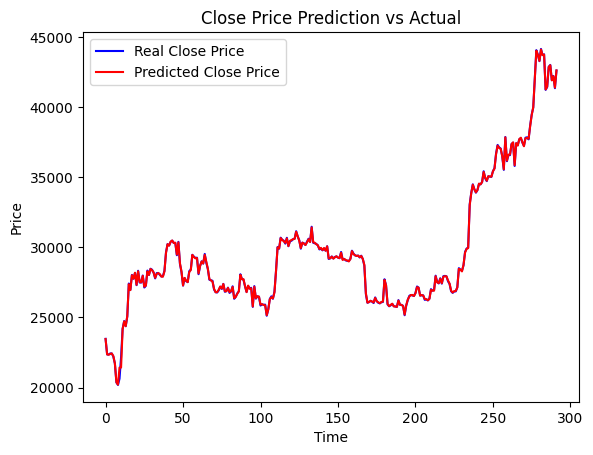

Line plot for Train Set: Scenario 2


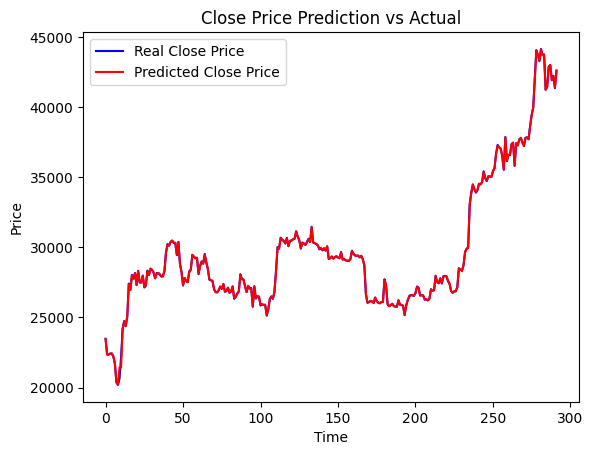

Line plot for Train Set: Scenario 3


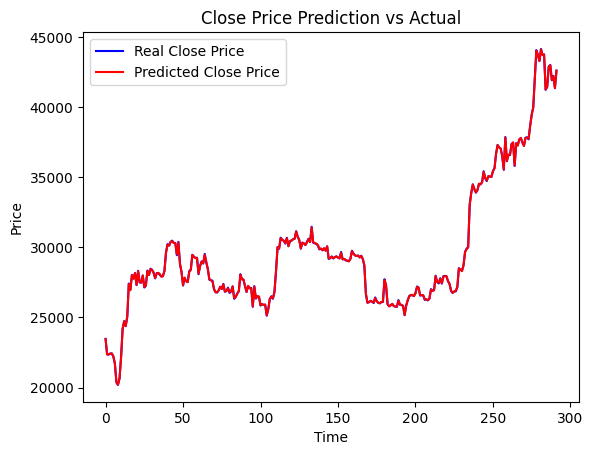

Line plot for Train Set: Scenario 4


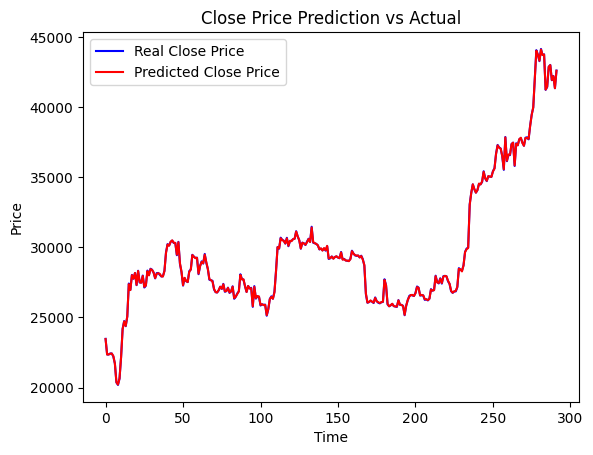

Line plot for Train Set: Scenario 5


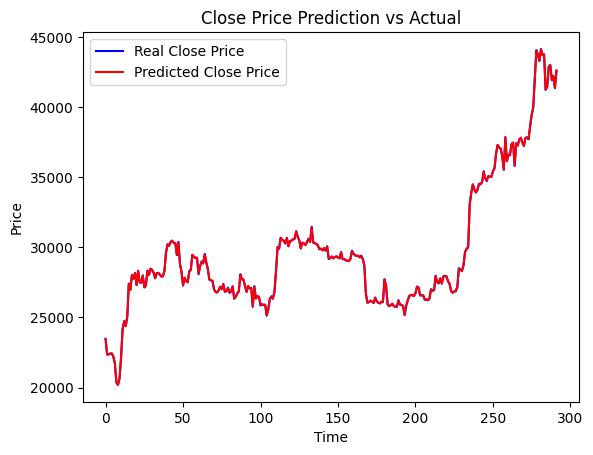

Line plot for Train Set: Scenario 6


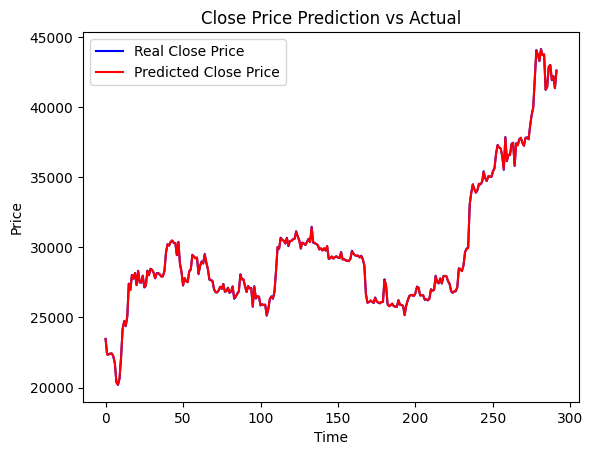

Line plot for Train Set: Scenario 7


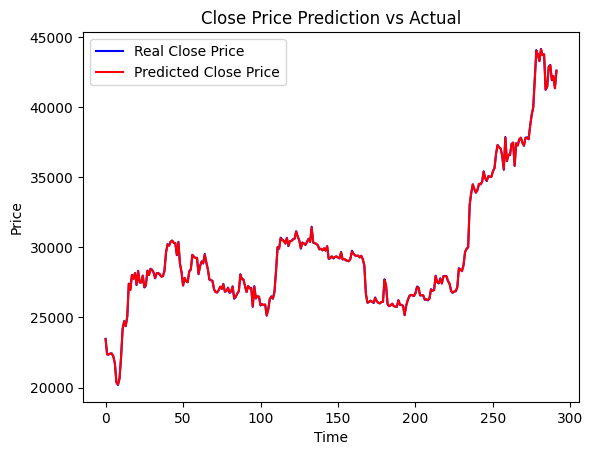

Line plot for Train Set: Scenario 8


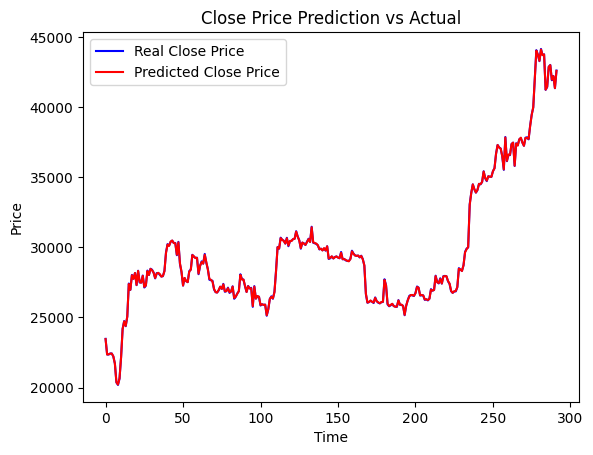

In [15]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    
    xgb_pred_train = model.predict(X_train_scenario)
    
    inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
    y_train_original = inverse_transform(scaler=scaler, predictions=y_train_scenario)

    print(f"Line plot for Train Set: Scenario {i}")
    lineplot(y_train_original, inverse_predictions_train)

## Scatter Plot Train

Scatter plot for Train Set: Scenario 1


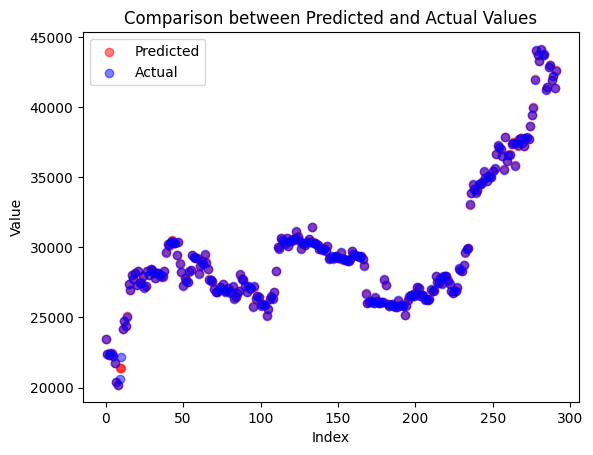

Scatter plot for Train Set: Scenario 2


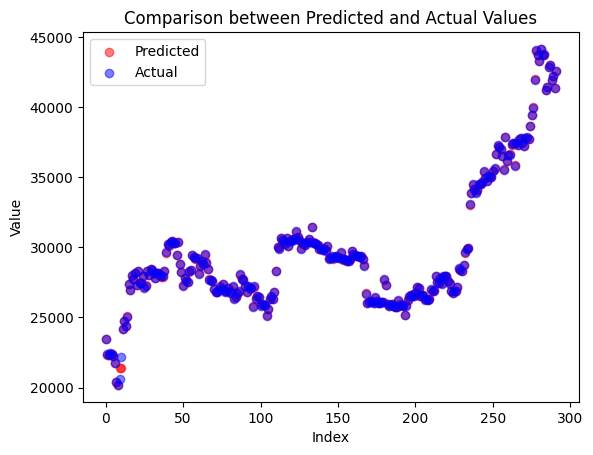

Scatter plot for Train Set: Scenario 3


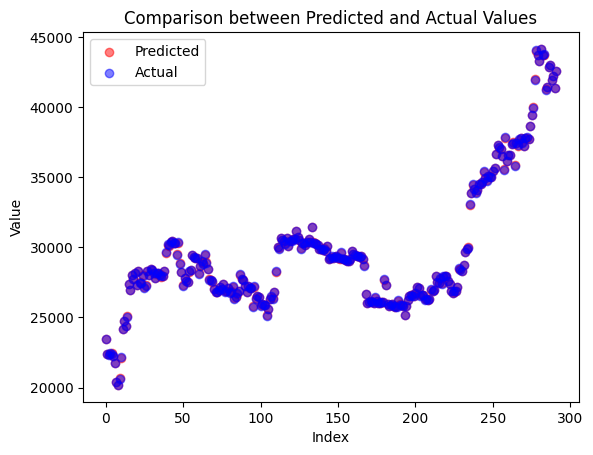

Scatter plot for Train Set: Scenario 4


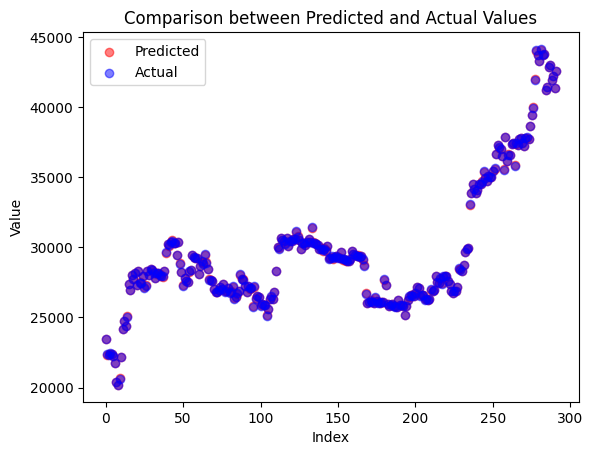

Scatter plot for Train Set: Scenario 5


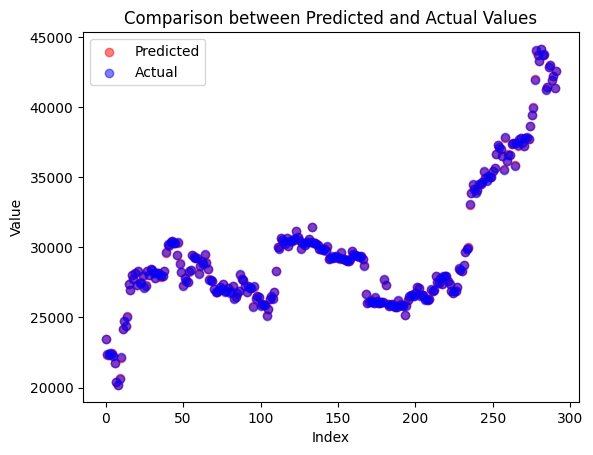

Scatter plot for Train Set: Scenario 6


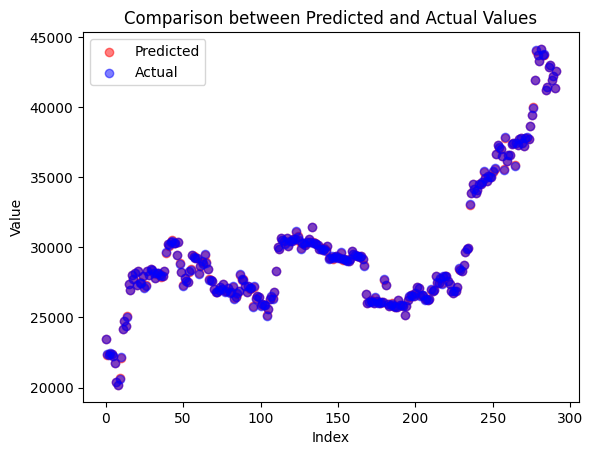

Scatter plot for Train Set: Scenario 7


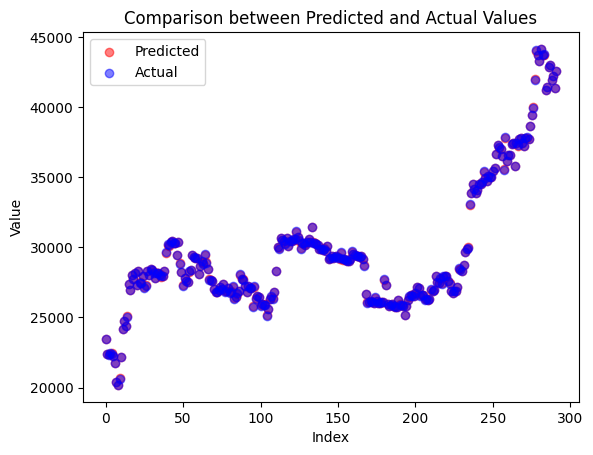

Scatter plot for Train Set: Scenario 8


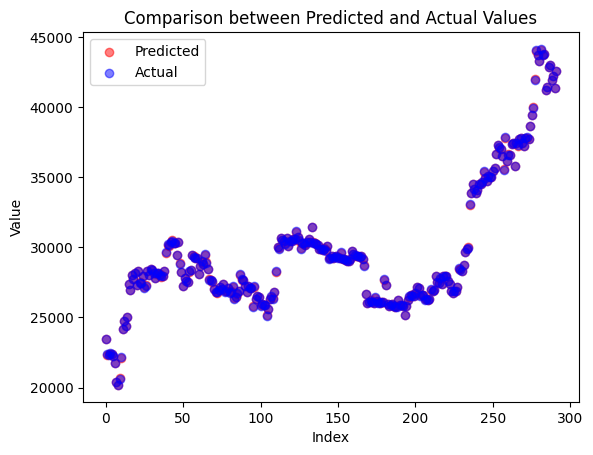

In [16]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    
    xgb_pred_train = model.predict(X_train_scenario)
    
    inverse_predictions_train = inverse_transform(scaler, xgb_pred_train)
    y_train_original = inverse_transform(scaler=scaler, predictions=y_train_scenario)

    print(f"Scatter plot for Train Set: Scenario {i}")
    scatterplot(y_train_original, inverse_predictions_train)

## Line Plot Test

Line plot for Test Set: Scenario 1


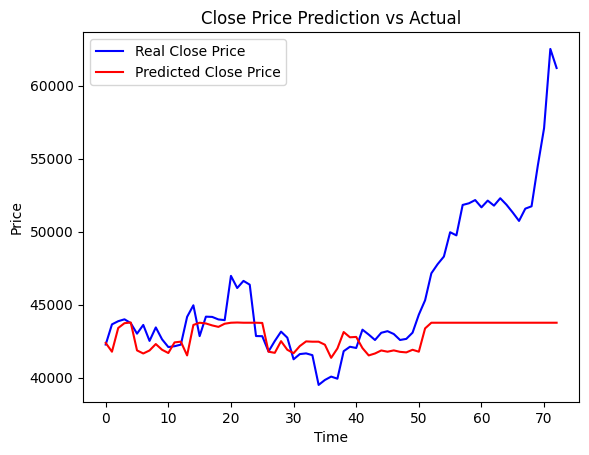

Line plot for Test Set: Scenario 2


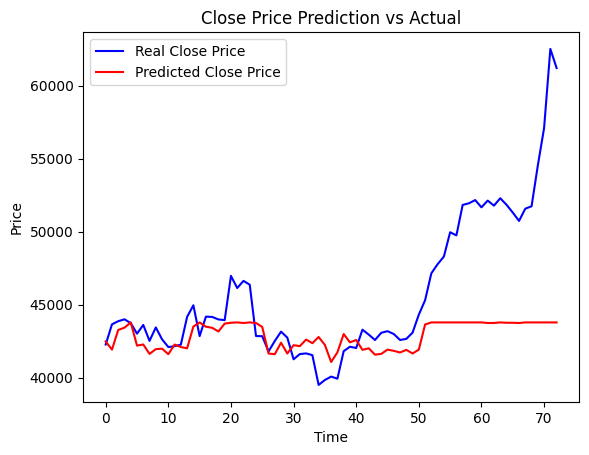

Line plot for Test Set: Scenario 3


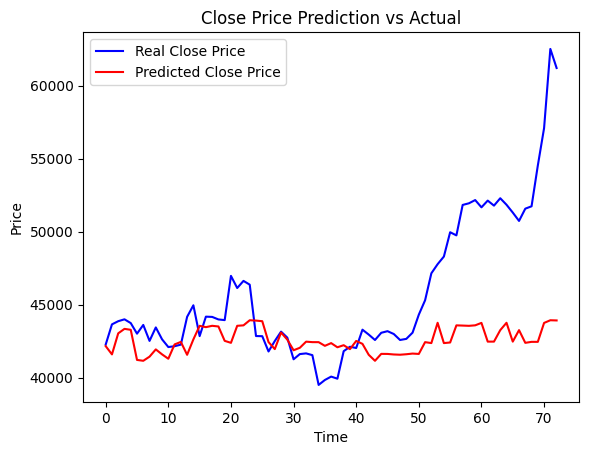

Line plot for Test Set: Scenario 4


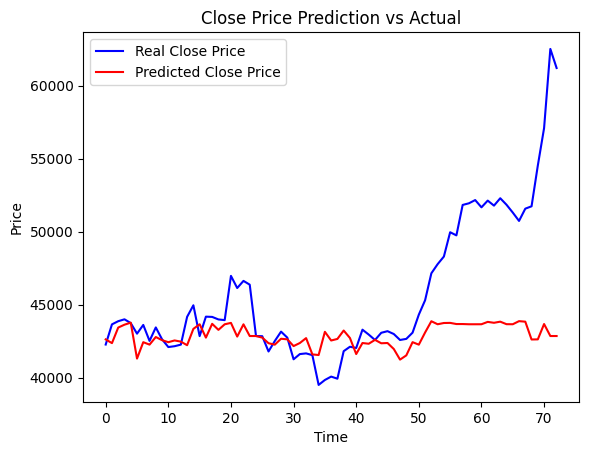

Line plot for Test Set: Scenario 5


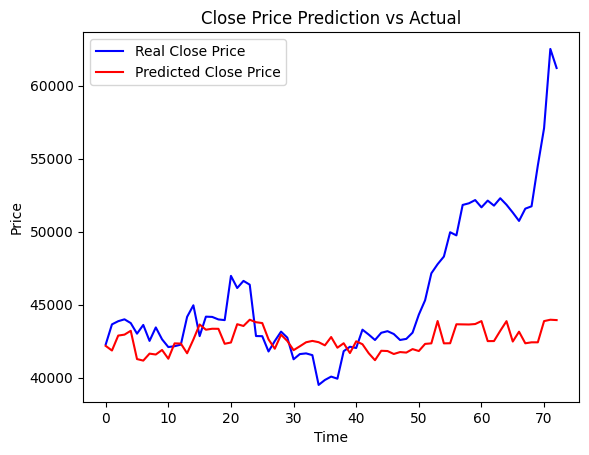

Line plot for Test Set: Scenario 6


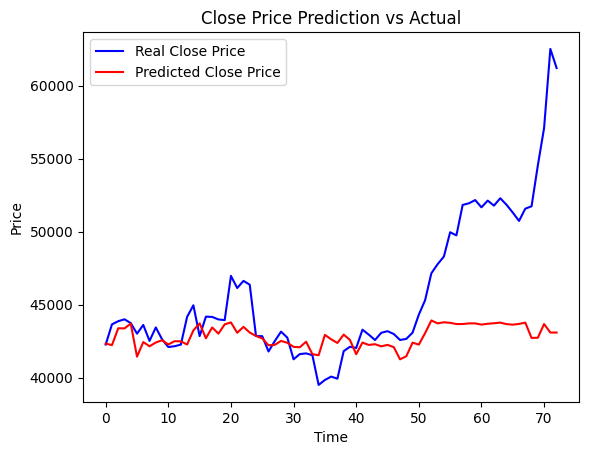

Line plot for Test Set: Scenario 7


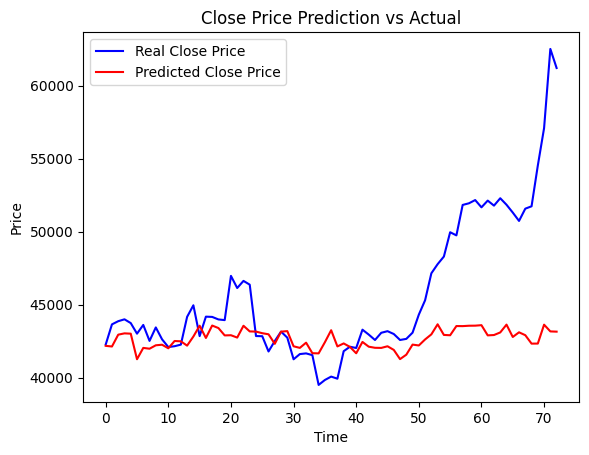

Line plot for Test Set: Scenario 8


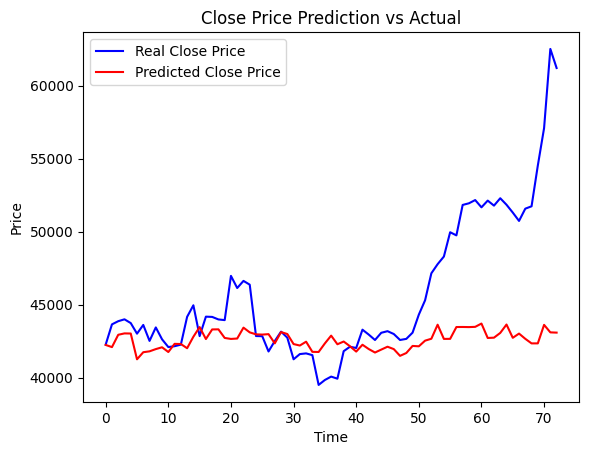

In [17]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]
    
    xgb_pred_test = model.predict(X_test_scenario)
    
    inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
    y_test_original = inverse_transform(scaler=scaler, predictions=y_test_scenario)

    print(f"Line plot for Test Set: Scenario {i}")
    lineplot(y_test_original, inverse_predictions_test)

## Scatter Plot Test

Scatter plot for Test Set: Scenario 1


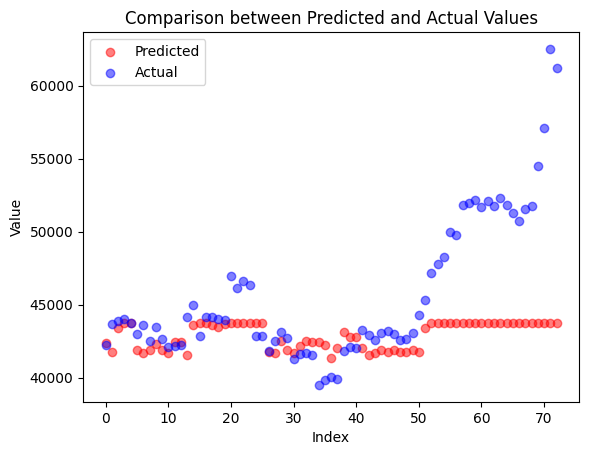

Scatter plot for Test Set: Scenario 2


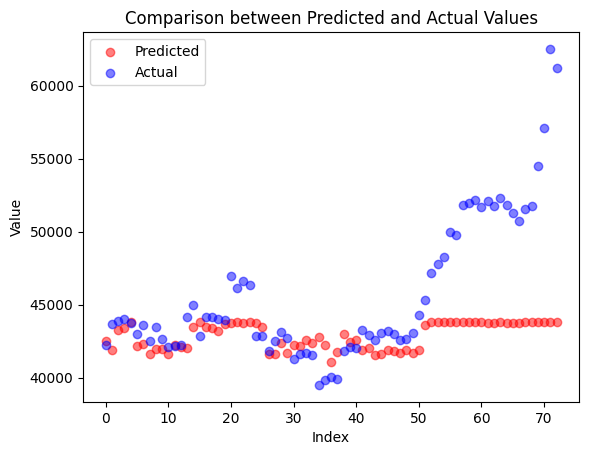

Scatter plot for Test Set: Scenario 3


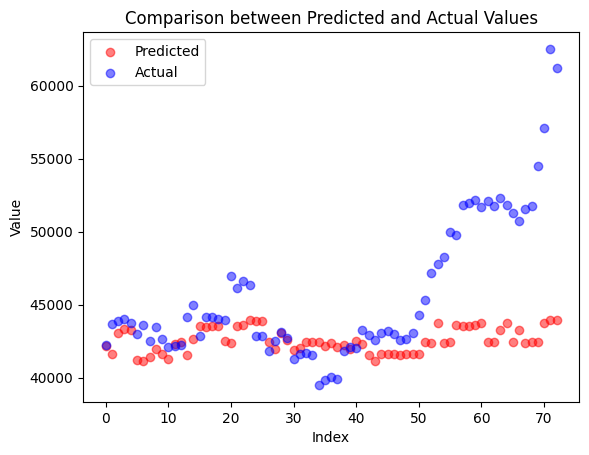

Scatter plot for Test Set: Scenario 4


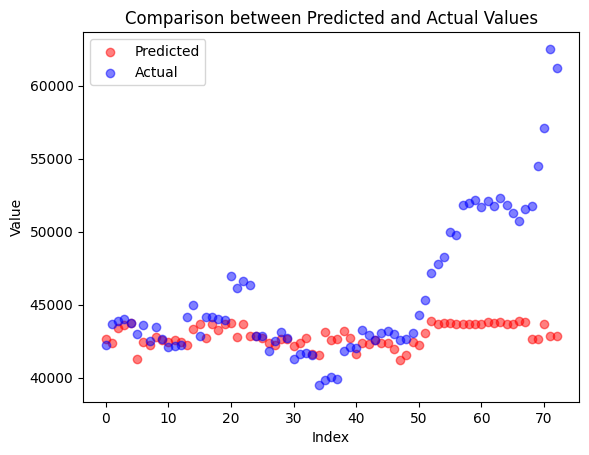

Scatter plot for Test Set: Scenario 5


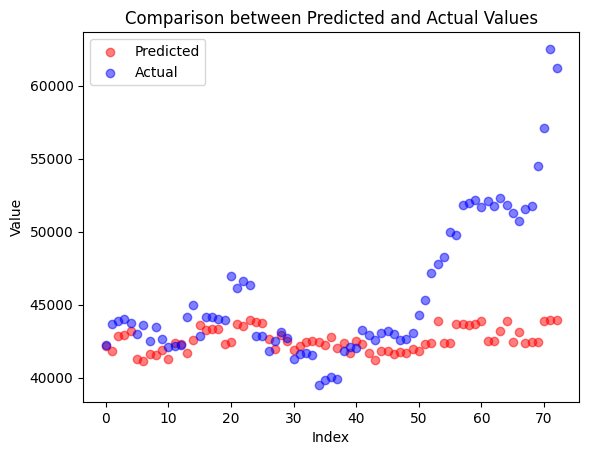

Scatter plot for Test Set: Scenario 6


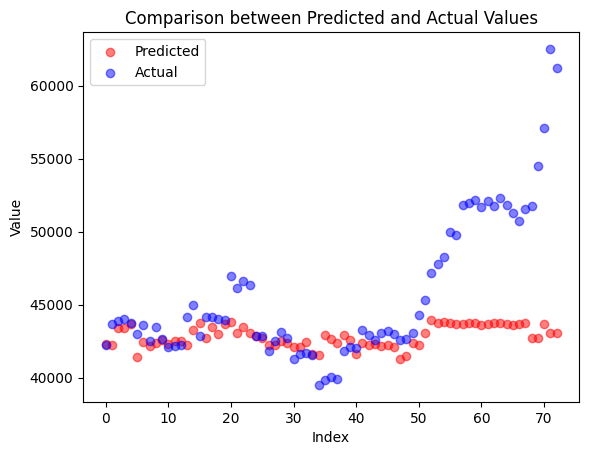

Scatter plot for Test Set: Scenario 7


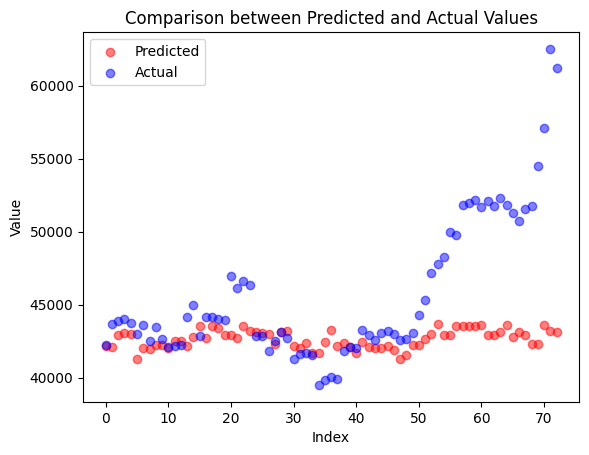

Scatter plot for Test Set: Scenario 8


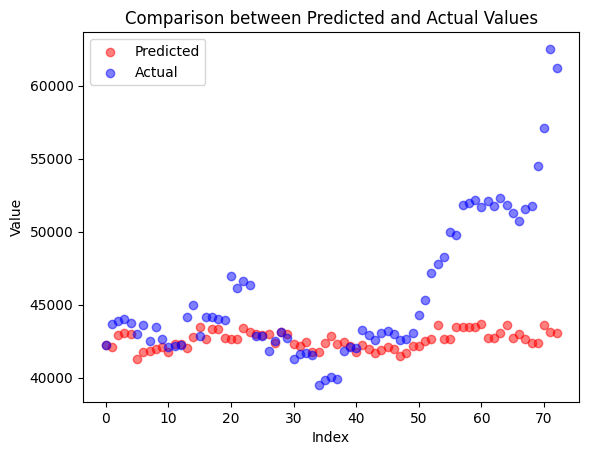

In [18]:
for i in range(1, 9):
    model = models[f"scen{i}"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]
    
    xgb_pred_test = model.predict(X_test_scenario)
    
    inverse_predictions_test = inverse_transform(scaler, xgb_pred_test)
    y_test_original = inverse_transform(scaler=scaler, predictions=y_test_scenario)

    print(f"Scatter plot for Test Set: Scenario {i}")
    scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [19]:
for i in range(1, 9):
    globals()[f"feature_names_scen{i}"] = scenarios[f"scen{i}"]

In [24]:
shap.initjs()

explainer = shap.TreeExplainer(model_scen2)
shap_values = explainer.shap_values(X_train_scen2)
i = 100

shap.force_plot(explainer.expected_value, shap_values[i], features=X_train_scen2[30], feature_names=feature_names_scen2)

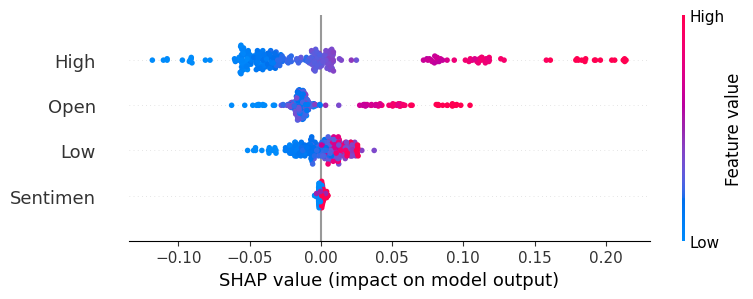

In [25]:
shap.summary_plot(shap_values, features=X_train_scen2, feature_names=feature_names_scen2)

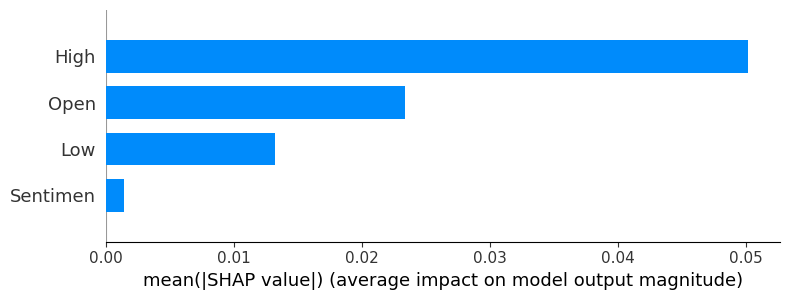

In [26]:
shap.summary_plot(shap_values, features=X_train_scen2, feature_names=feature_names_scen2, plot_type="bar")

# TEST DENGAN DATA BARU

In [51]:
dt = pd.read_excel('Data/all_data_validation.xlsx')
dt.head()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,40186368423,positif,59,62440.632813
1,2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,23888473685,positif,46,62029.847656
2,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,26253811450,positif,44,63167.371094
3,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,70670471105,positif,81,68330.414063
4,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,102802940877,positif,100,63801.199219


In [52]:
dt = dt.drop(columns=["Date", 'Adj_Close', 'Volume', 'Index'])

In [53]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [54]:
dt.describe()

,Open,High,Low,Sentimen,Close
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,0.548387,67702.439264
std,3292.243235,2911.385403,3273.325051,0.809885,3157.882425
min,61168.062500,62458.699219,59323.910156,-1.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,0.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,1.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,1.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,1.000000,73083.500000


In [55]:
X, y, scalers = scale_data(dt)

In [56]:
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])

In [60]:
predictions = model_scen2.predict(X) 

inverse_predictions_new = inverse_transform(scalers, predictions)
y_test_original_new = inverse_transform(scalers, y)

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new, 'Actual': y_test_original_new})
compare_model_test

,Predicted,Actual
0,63034.058050,62029.847656
1,63180.998704,63167.371094
2,62907.368032,68330.414063
3,66200.530747,63801.199219
4,67687.119782,66106.804688
5,66236.780376,66925.484375
6,67220.387240,68300.093750
7,68179.980381,68498.882813
8,68053.625689,69019.789063
9,68131.904328,72123.906250


In [61]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 2698.8459577535077
R-squared Test Set: 0.19235885483486936


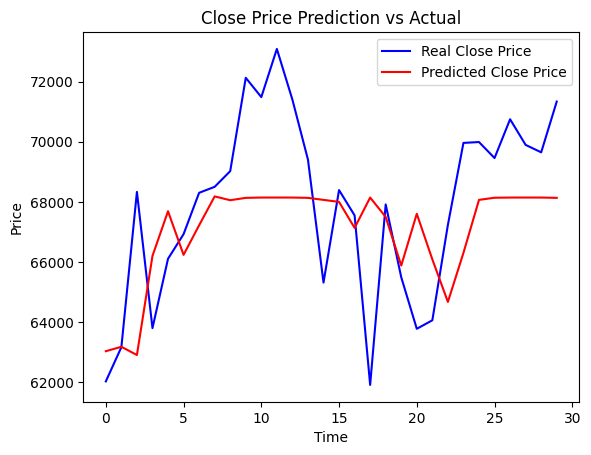

In [62]:
lineplot(y_test_original_new, inverse_predictions_new)

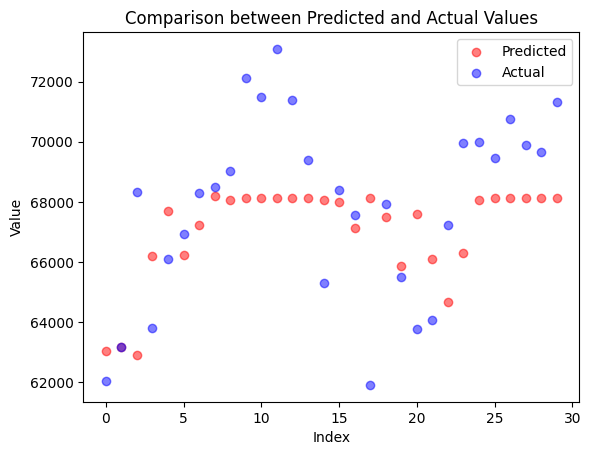

In [63]:
scatterplot(y_test_original_new, inverse_predictions_new)